# GPS data tretament

note: in this notebook lines for all the paths (NOT the buffers) are created and also the hex grid cell and boundaries of cph. 
in another notebook are redone the lines and the buffers ì 

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from functools import reduce

import geopandas as gpd
from shapely.geometry import LineString
from shapely.geometry import Polygon

import contextily as ctx

import osmnx as ox  

from pyproj import Transformer

In [2]:
data_path = '/home/s232713/data/'

In [3]:

gps_data_cleaned = pd.read_csv(data_path + "clean_points.csv", sep=';')

In [4]:
gps_data_cleaned.head()

,Interval ID,Latitude,Longitude
0,628692,55.68615,12.53335
1,628692,55.68595,12.53373
2,628692,55.68568,12.53419
3,628692,55.68551,12.53460
4,628692,55.68545,12.53540


In [5]:
# gps_data_cleaned.head()
len(gps_data_cleaned['Interval ID'].unique())

14560

In [6]:
# geodataframe creation
gdf = gpd.GeoDataFrame(
    gps_data_cleaned,
    geometry=gpd.points_from_xy(gps_data_cleaned["Longitude"], gps_data_cleaned["Latitude"]),
    crs="EPSG:4326"  # WGS84 latitude/longitude
)

# points to lines
lines = []

for interval_id, group in gdf.groupby("Interval ID"):
    # group = group.sort_values("Sequence No.")
    
    coords = list(group.geometry)
    if len(coords) > 1:  # need at least 2 points to form a line
        line = LineString(coords)
        lines.append({"Interval ID": interval_id, "geometry": line})

# Create a GeoDataFrame from the lines
lines_gdf = gpd.GeoDataFrame(lines, crs="EPSG:4326")

'''# Save the lines GeoDataFrame to a file
lines_gdf.to_file("trips_lines.geojson", driver="GeoJSON")
lines_gdf.to_file("trips_lines.shp") 
'''

print(f"Created {len(lines_gdf)} trip lines")


KeyboardInterrupt: 

In [7]:
lines_gdf.head() # gdf dataset gouped by 'Interval ID' 
# 'geometry' it's a line connecting all the points with the same 'Interval ID' it's structured like A → B → C

,Interval ID,geometry
0,264953,"LINESTRING (12.51884 55.78052, 12.51932 55.780..."
1,264954,"LINESTRING (12.52025 55.78022, 12.52389 55.780..."
2,264966,"LINESTRING (12.51756 55.77981, 12.51783 55.780..."
3,264967,"LINESTRING (12.52068 55.78049, 12.52017 55.780..."
4,265108,"LINESTRING (12.50019 55.88168, 12.49976 55.881..."


In [8]:
print(len(lines_gdf) == len(gps_data_cleaned['Interval ID'].unique())) 
# it's true because lines_gdf it's grouped by 'Interval ID'

True


In [9]:
gdf.head()

,Interval ID,Latitude,Longitude,geometry
0,628692,55.68615,12.53335,POINT (12.53335 55.68615)
1,628692,55.68595,12.53373,POINT (12.53373 55.68595)
2,628692,55.68568,12.53419,POINT (12.53419 55.68568)
3,628692,55.68551,12.53460,POINT (12.5346 55.68551)
4,628692,55.68545,12.53540,POINT (12.5354 55.68545)


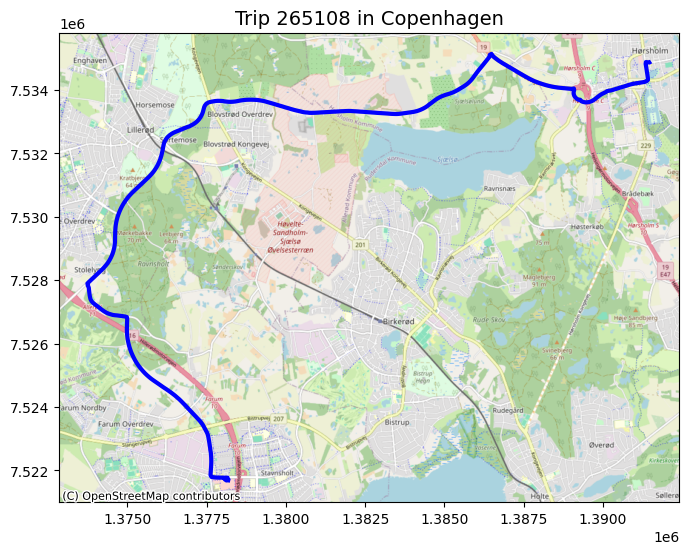

In [10]:
# 1. Select one trip by Interval ID
trip_id = 265108  # replace with your ID
trip = lines_gdf[lines_gdf["Interval ID"] == trip_id]

# 2. Reproject to Web Mercator (needed for contextily tiles)
trip_web = trip.to_crs(epsg=3857)

# 3. Plot
fig, ax = plt.subplots(figsize=(8,8))
trip_web.plot(ax=ax, color="blue", linewidth=3)

# Add basemap (OpenStreetMap default)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add title
ax.set_title(f"Trip {trip_id} in Copenhagen", fontsize=14)

plt.show()

In [11]:
#gdf.head() # for every point in the dataset i have a geometry which is a line connecting all the points with the same 'Interval ID'

| Interval ID   | Mean_HR  | Stress   | geometry              |
|---------------|----------| ---------| ----------------------|
| 1             | 72.3     | 0        | LINESTRING(A → B → C) |
| 1             | 85.1     | 1        | LINESTRING(A → B → C) |
| 2             | 66.0     | 0        | LINESTRING(D → E → F) |

example on how i think it might be merged with the big dataset in order to keep the lines and the physiological features 

shall use lines_gdf for the linestring and merge on interval id 





# CPH grid cell

In [8]:
# boundaries
cph = ox.geocode_to_gdf("Copenhagen Municipality, Denmark")
print(cph)

cph.to_file(data_path + "grid_data/copenhagen_boundary.geojson", driver="GeoJSON")


                                            geometry  bbox_west  bbox_south  \
0  MULTIPOLYGON (((12.453 55.71222, 12.45301 55.7...  12.452998   55.612861   

   bbox_east  bbox_north   place_id  osm_type   osm_id        lat        lon  \
0  12.734246   55.732712  136748712  relation  2192363  55.662438  12.602552   

      class            type  place_rank  importance   addresstype  \
0  boundary  administrative          14    0.533465  municipality   

                      name                                       display_name  
0  Copenhagen Municipality  Copenhagen Municipality, Capital Region of Den...  


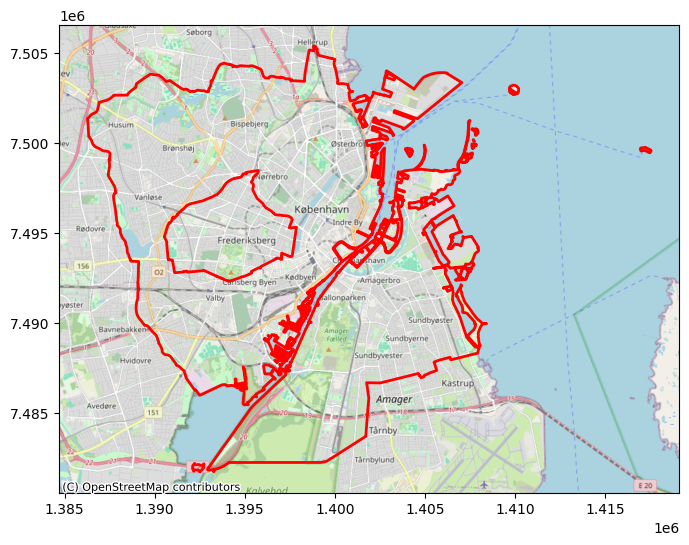

In [9]:
# quick check of the boundary
cph_web = cph.to_crs(epsg=3857)

ax = cph_web.plot(edgecolor="red", facecolor="none", linewidth=2, figsize=(8,8))
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

the municipalities have been extracetd for all the grater copenhagen region following the official link: https://www.regionh.dk/om-region-hovedstaden/fakta/kommunerne-i-region-hovedstaden/sider/kommuner-i-region-hovedstaden.aspx

In [10]:
# --- Municipalities to include (core Copenhagen + Frederiksberg + first ring) ---
munis = [
    "Københavns Kommune, Denmark",
    "Frederiksberg Kommune, Denmark",
    "Tårnby Kommune, Denmark",
    "Dragør Kommune, Denmark",
    "Hvidovre Kommune, Denmark",
    "Rødovre Kommune, Denmark",
    "Gladsaxe Kommune, Denmark",
    "Gentofte Kommune, Denmark",
    "Lyngby-Taarbæk Kommune, Denmark",
    "Herlev Kommune, Denmark",
    "Brøndby Kommune, Denmark",
    "Vallensbæk Kommune, Denmark",
    "Ishøj Kommune, Denmark",
    "Høje-Taastrup Kommune, Denmark",
    "Albertslund Kommune, Denmark",
    "Ballerup Kommune, Denmark",
    "Glostrup Kommune, Denmark",
    "Furesø Kommune, Denmark",
    "Egedal Kommune, Denmark",
    "Rudersdal Kommune, Denmark",
    "Hørsholm Kommune, Denmark",
    "Fredensborg Kommune, Denmark",
    "Allerød Kommune, Denmark",
    "Hillerød Kommune, Denmark",
    "Gribskov Kommune, Denmark",
    "Halsnæs Kommune, Denmark",
    "Frederikssund Kommune, Denmark",
    "Helsingør Kommune, Denmark",
    #"Bornholms Regionskommune, Denmark"  # it's an island in the baltic sea
]


In [11]:
# --- Download boundaries from OSM ---
gdfs = [ox.geocode_to_gdf(m) for m in munis]

# concat into one GeoDataFrame
area = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)

# dissolve into single polygon
area["ones"] = 1
cph_union = area.dissolve(by="ones")

# --- Save to file ---
cph_union.to_file(data_path + "grid_data/copenhagen_union_boundary.geojson", driver="GeoJSON") # save first ring boundary

print(cph_union)

                                               geometry  bbox_west  \
ones                                                                 
1     MULTIPOLYGON (((12.02308 55.71441, 12.02308 55...  12.452998   

      bbox_south  bbox_east  bbox_north   place_id  osm_type   osm_id  \
ones                                                                    
1      55.612861  12.734246   55.732712  136748712  relation  2192363   

            lat        lon     class            type  place_rank  importance  \
ones                                                                           
1     55.662438  12.602552  boundary  administrative          14    0.533465   

       addresstype                     name  \
ones                                          
1     municipality  Copenhagen Municipality   

                                           display_name  
ones                                                     
1     Copenhagen Municipality, Capital Region of Den...  


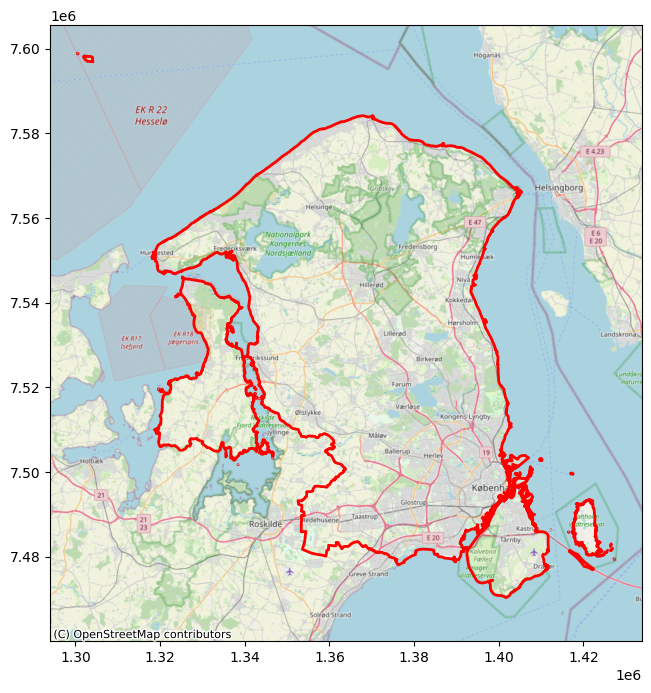

In [12]:
# quick check of the boundary
cph_web = cph_union.to_crs(epsg=3857)

ax = cph_web.plot(edgecolor="red", facecolor="none", linewidth=2, figsize=(8,8))
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

comaprison between wich area oof cph consider, the first one is only cph municipality the second is the first ring including other municipality. first ring has been considered becuase is where people usually move. nee to check which one is better. 

In [13]:
gdf_in = gdf[gdf.within(cph.geometry.iloc[0])]

n_total = len(gdf)
n_inside = len(gdf_in)
n_outside = n_total - n_inside

print(f"Total GPS points: {n_total}")
print(f"Inside Copenhagen greater area: {n_inside}") # same values if i consider Bornholms Regionskommune or not
print(f"Outside (would be removed): {n_outside}")

Total GPS points: 1923328
Inside Copenhagen greater area: 284983
Outside (would be removed): 1638345


creating the grid cell using ofr now the cph municipality. easier and faster and then we'll see which one we'll use

In [26]:
# --------------------making hexagonal grid---------------------
cph_union = cph_union.to_crs(epsg=25833) 
s = 50  
hex_width = 2 * s
hex_height = np.sqrt(3) * s

# Bounding box 
minx, miny, maxx, maxy = cph_union.total_bounds

# Step size
x_step = hex_width * 0.75      
y_step = hex_height  

hexes = []
x = minx
col = 1
while x < maxx + hex_width:
    y = miny
    if col % 2 == 1:  
        y += hex_height / 2   # offset vertical
    while y < maxy + hex_height:
        # flat-top
        coords = [
            (x + s, y),
            (x + s/2, y + (np.sqrt(3)/2)*s),
            (x - s/2, y + (np.sqrt(3)/2)*s),
            (x - s, y),
            (x - s/2, y - (np.sqrt(3)/2)*s),
            (x + s/2, y - (np.sqrt(3)/2)*s),
            (x + s, y)
        ]
        hexes.append(Polygon(coords))
        y += y_step
    x += x_step
    col += 1


grid = gpd.GeoDataFrame(geometry=hexes, crs="EPSG:25833") 
grid = grid[grid.intersects(cph_union.unary_union)].reset_index(drop=True) # version that keep only the hexagons that intersect with the cph_union boundary
# grid = gpd.overlay(grid, cph_union, how="intersection") # clipped version of the edge hexagons

grid["GRID_ID"] = range(len(grid))

# Centroids
centroids = grid.copy()
centroids["geometry"] = centroids.centroid
centroids = centroids.to_crs(epsg=4326)  # back to lat/lon
centroids["lon"] = centroids.geometry.x
centroids["lat"] = centroids.geometry.y

# save outputs like requested 
grid.to_file(data_path + "grid_data/cph_hexgrid.geojson", driver="GeoJSON")
centroids[["GRID_ID", "lat", "lon"]].to_csv(data_path + "grid_data/cph_hexgrid_centroids.csv", index=False)


/tmp/ipykernel_43123/4281083688.py:39: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid = grid[grid.intersects(cph_union.unary_union)].reset_index(drop=True) # version that keep only the hexagons that intersect with the cph_union boundary


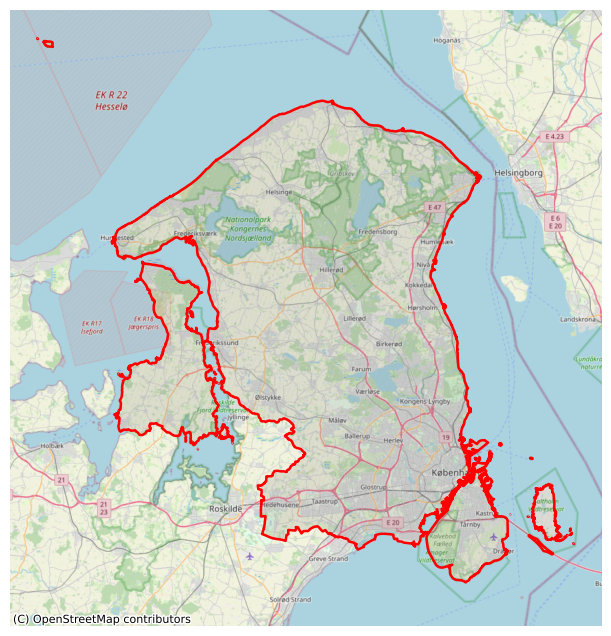

In [3]:
grid = gpd.read_file('/home/s232713/data/grid_data/cph_hexgrid.geojson')
cph_union = gpd.read_file('/home/s232713/data/grid_data/copenhagen_union_boundary.geojson')

cph_web = cph_union.to_crs(epsg=3857)
grid_web = grid.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(8, 8))

# plot hexagonal grid VERY lightly
grid_web.plot(
    ax=ax,
    facecolor="none",
    edgecolor="grey",
    linewidth=0.1,
    alpha=0.2
)

# plot boundary outline clearly
cph_web.plot(
    ax=ax,
    facecolor="none",
    edgecolor="red",
    linewidth=1.8
)

# add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.show()

fig.canvas.draw()

outpath = "/home/s232713/figures/cph_hexgrid_full_extent.pdf"
fig.savefig(
    outpath,
    format="pdf",
    bbox_inches="tight"
)

plt.close(fig)


In [4]:
print('Number of hexagons:', len(grid))

Number of hexagons: 308878


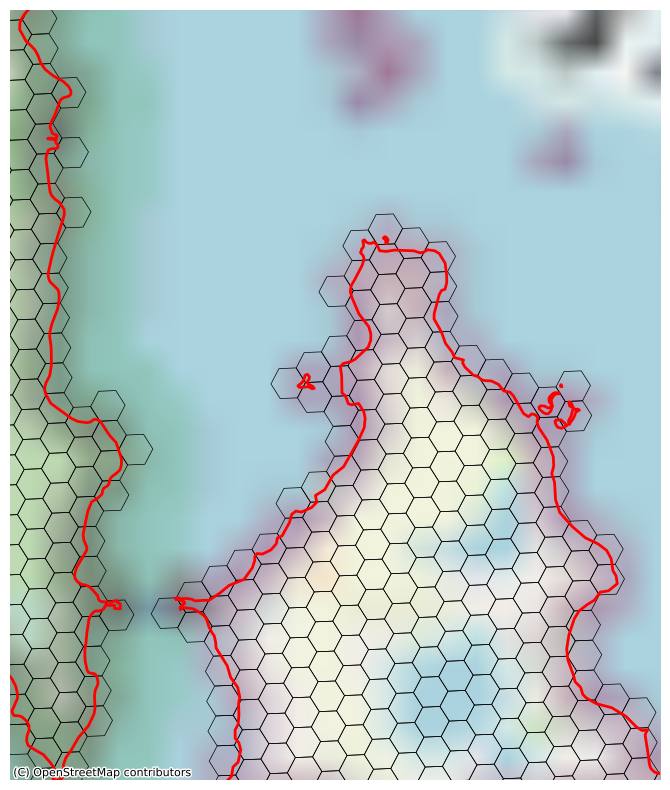

In [12]:
#### check if the hexagons are well placed ####
# define your zoom box in lat/lon (WGS84)

lat_min, lat_max = 55.73, 55.75
lon_min, lon_max = 12.06, 12.09

# convert to Web Mercator (EPSG:3857)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
x_min, y_min = transformer.transform(lon_min, lat_min)
x_max, y_max = transformer.transform(lon_max, lat_max)

fig, ax = plt.subplots(figsize=(10, 10))

'''# odds and fairly centered grid different color for better visibility
if grid.centroid.x.mean() % 2 == 0:
    grid_web_even = grid_web[grid_web.centroid.x.astype(int) % 2 == 0]
    grid_web_odd = grid_web[grid_web.centroid.x.astype(int) % 2 == 1]
    grid_web_even.plot(ax=ax, facecolor="none", edgecolor="blue", linewidth=0.3)
    grid_web_odd.plot(ax=ax, facecolor="none", edgecolor="cyan", linewidth=0.3)
else:
    grid_web_odd = grid_web[grid_web.centroid.x.astype(int) % 2 == 1]
    grid_web_even = grid_web[grid_web.centroid.x.astype(int) % 2 == 0]
    grid_web_odd.plot(ax=ax, facecolor="none", edgecolor="blue", linewidth=0.3)
    grid_web_even.plot(ax=ax, facecolor="none", edgecolor="cyan", linewidth=0.3)'''


grid_web.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5)
cph_web.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# set zoom window
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

ax.set_axis_off()
plt.show()

outpath = "/home/s232713/figures/cph_hexgrid_zoom.pdf"
fig.savefig(
    outpath,
    format="pdf",
    bbox_inches="tight"
)

plt.close(fig)

check to see if there are no hexagonal cells 

In [31]:
import geopandas as gpd
import pandas as pd

# === Load data ===
hexes = gpd.read_file("/home/s232713/data/grid_data/cph_hexgrid.geojson")
centroids = pd.read_csv("/home/s232713/data/grid_data/cph_hexgrid_centroids.csv")
grid_to_trip = pd.read_csv("/home/s232713/data/grid_data/grid_to_trip.csv")

# === Create GeoDataFrame of centroids ===
centroids_gdf = gpd.GeoDataFrame(
    centroids,
    geometry=gpd.points_from_xy(centroids.lon, centroids.lat),
    crs="EPSG:4326"
).to_crs(hexes.crs)

# === Spatial join ===
hexes = gpd.sjoin(hexes, centroids_gdf[["GRID_ID", "geometry"]], predicate="contains", how="left")

grid_col = [c for c in hexes.columns if "GRID_ID" in c][0]
print("Using column:", grid_col)

# === Keep only active hexes ===
active_hex = hexes[hexes[grid_col].isin(grid_to_trip["GRID_ID"])].copy()

# === Count vertices ===
active_hex["n_vertices"] = active_hex.geometry.apply(
    lambda geom: len(geom.exterior.coords) - 1 if geom.geom_type == "Polygon" else 0
)
active_hex["is_hexagon"] = active_hex["n_vertices"] == 6

# === Identify clipped ones ===
non_hex = active_hex[~active_hex["is_hexagon"]]
print(f"Total active hexagons: {len(active_hex)}")
print(f"Non-hexagonal (clipped) active ones: {len(non_hex)}")

# non_hex.to_file("/home/s232713/data/grid_data/non_hex_active.geojson", driver="GeoJSON")



Using column: GRID_ID_left
Total active hexagons: 12920
Non-hexagonal (clipped) active ones: 0


/tmp/ipykernel_43123/2274081745.py:18: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  non_hex_centroids.plot(ax=ax, color="red", markersize=15, label="Clipped hex centroids")


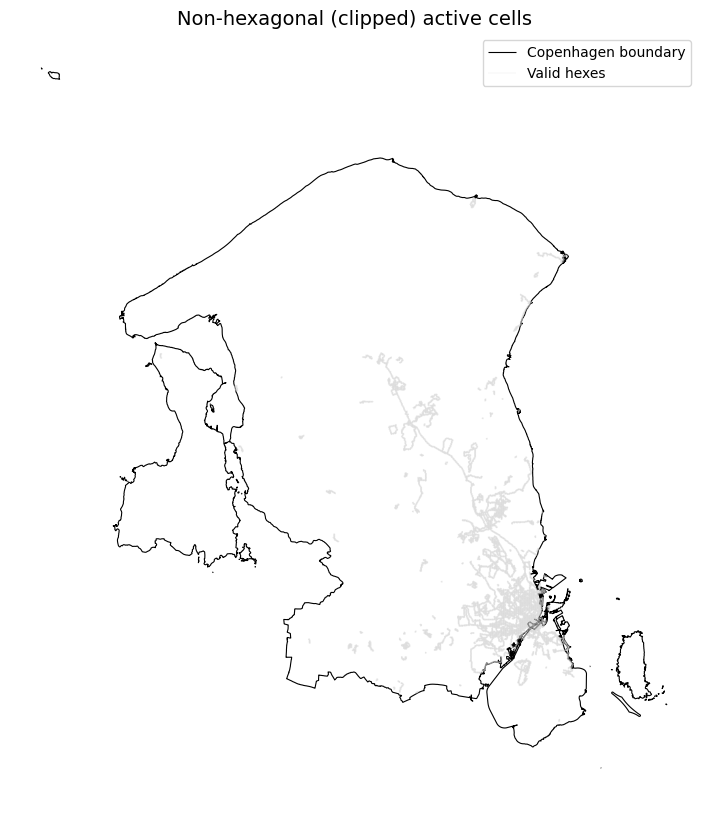

In [32]:
import matplotlib.pyplot as plt

# === Load the Copenhagen boundary ===
cph_boundary = gpd.read_file("/home/s232713/data/grid_data/copenhagen_union_boundary.geojson").to_crs(hexes.crs)

# === Merge centroids info so we can get coordinates for non-hex cells ===
centroids_gdf = centroids_gdf.rename(columns={"GRID_ID": "GRID_ID_centroid"})
grid_col = [c for c in hexes.columns if "GRID_ID" in c][0]

# Extract centroids of the non-hex cells
non_hex_ids = non_hex[grid_col].dropna().unique()
non_hex_centroids = centroids_gdf[centroids_gdf["GRID_ID_centroid"].isin(non_hex_ids)]

# === Plot ===
fig, ax = plt.subplots(figsize=(10, 10))
cph_boundary.boundary.plot(ax=ax, color="black", linewidth=0.8, label="Copenhagen boundary")
active_hex.boundary.plot(ax=ax, color="lightgray", linewidth=0.3, label="Valid hexes", alpha=0.5)
non_hex_centroids.plot(ax=ax, color="red", markersize=15, label="Clipped hex centroids")

plt.title("Non-hexagonal (clipped) active cells", fontsize=14)
plt.legend()
plt.axis("off")
plt.show()
